# Example on visualising the dataset.

We use qiskit to run quantum circuit. Then we plot the dataset usign t-SNE or MDS.

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qiskit import QuantumCircuit, execute, Aer
from sklearn.manifold import MDS
from sklearn.manifold import TSNE

from utils import qc_reader

In [2]:
# load qasm data
qasm_datas, labels = qc_reader.load_qc(path="../data/qasm", n_qubit=12)

In [3]:
# convert qasm to quantum state

def get_state_from_qasm(qasm_str: str):
    # convert qasm to QuantumCircuit object
    qc = QuantumCircuit.from_qasm_str(qasm_str)
    job = execute(qc, Aer.get_backend('statevector_simulator'))
    state = job.result().get_statevector()

    return state


state_list = []
for i, qasm_str in enumerate(qasm_datas):
    progress_str = f"Converting: {(i + 1) / len(qasm_datas) * 100:.2f}%"
    print("\r"+str(progress_str),end="")
    state = get_state_from_qasm(qasm_str=qasm_str)
    state_list.append(state)

Converting: 100.00%

In [4]:
def get_distance_matrix(state_list: list):
    _distance_matrix = np.zeros([len(state_list), len(state_list)])
    for index1, state1 in enumerate(state_list):
        for index2, state2 in enumerate(state_list):
            fidelity = np.abs(np.vdot(state1, state2)) ** 2
            _distance_matrix[index1][index2] = 1 - fidelity

    # Correct any calculation errors.
    if np.min(_distance_matrix) < 0:
        print(np.min(_distance_matrix))
        distance_matrix = _distance_matrix.copy() - np.min(_distance_matrix)
    else:
        distance_matrix = _distance_matrix.copy()
    return distance_matrix


distance_matrix = get_distance_matrix(state_list=state_list)

-2.0872192862952943e-14


In [5]:
def _plot(df):
    fig, ax = plt.subplots(figsize=(6, 6), dpi=400)
    plt.xticks([])
    plt.yticks([])
    ax.grid(which="major", axis="y")
    ax.grid(which="major", axis="x")
    color_obj = matplotlib.cm.tab10

    for label in labels:
        _df = df.query(f"label=={label}")
        ax.scatter(_df.xdata, _df.ydata, color=color_obj.colors[label], s=10)
    plt.show()

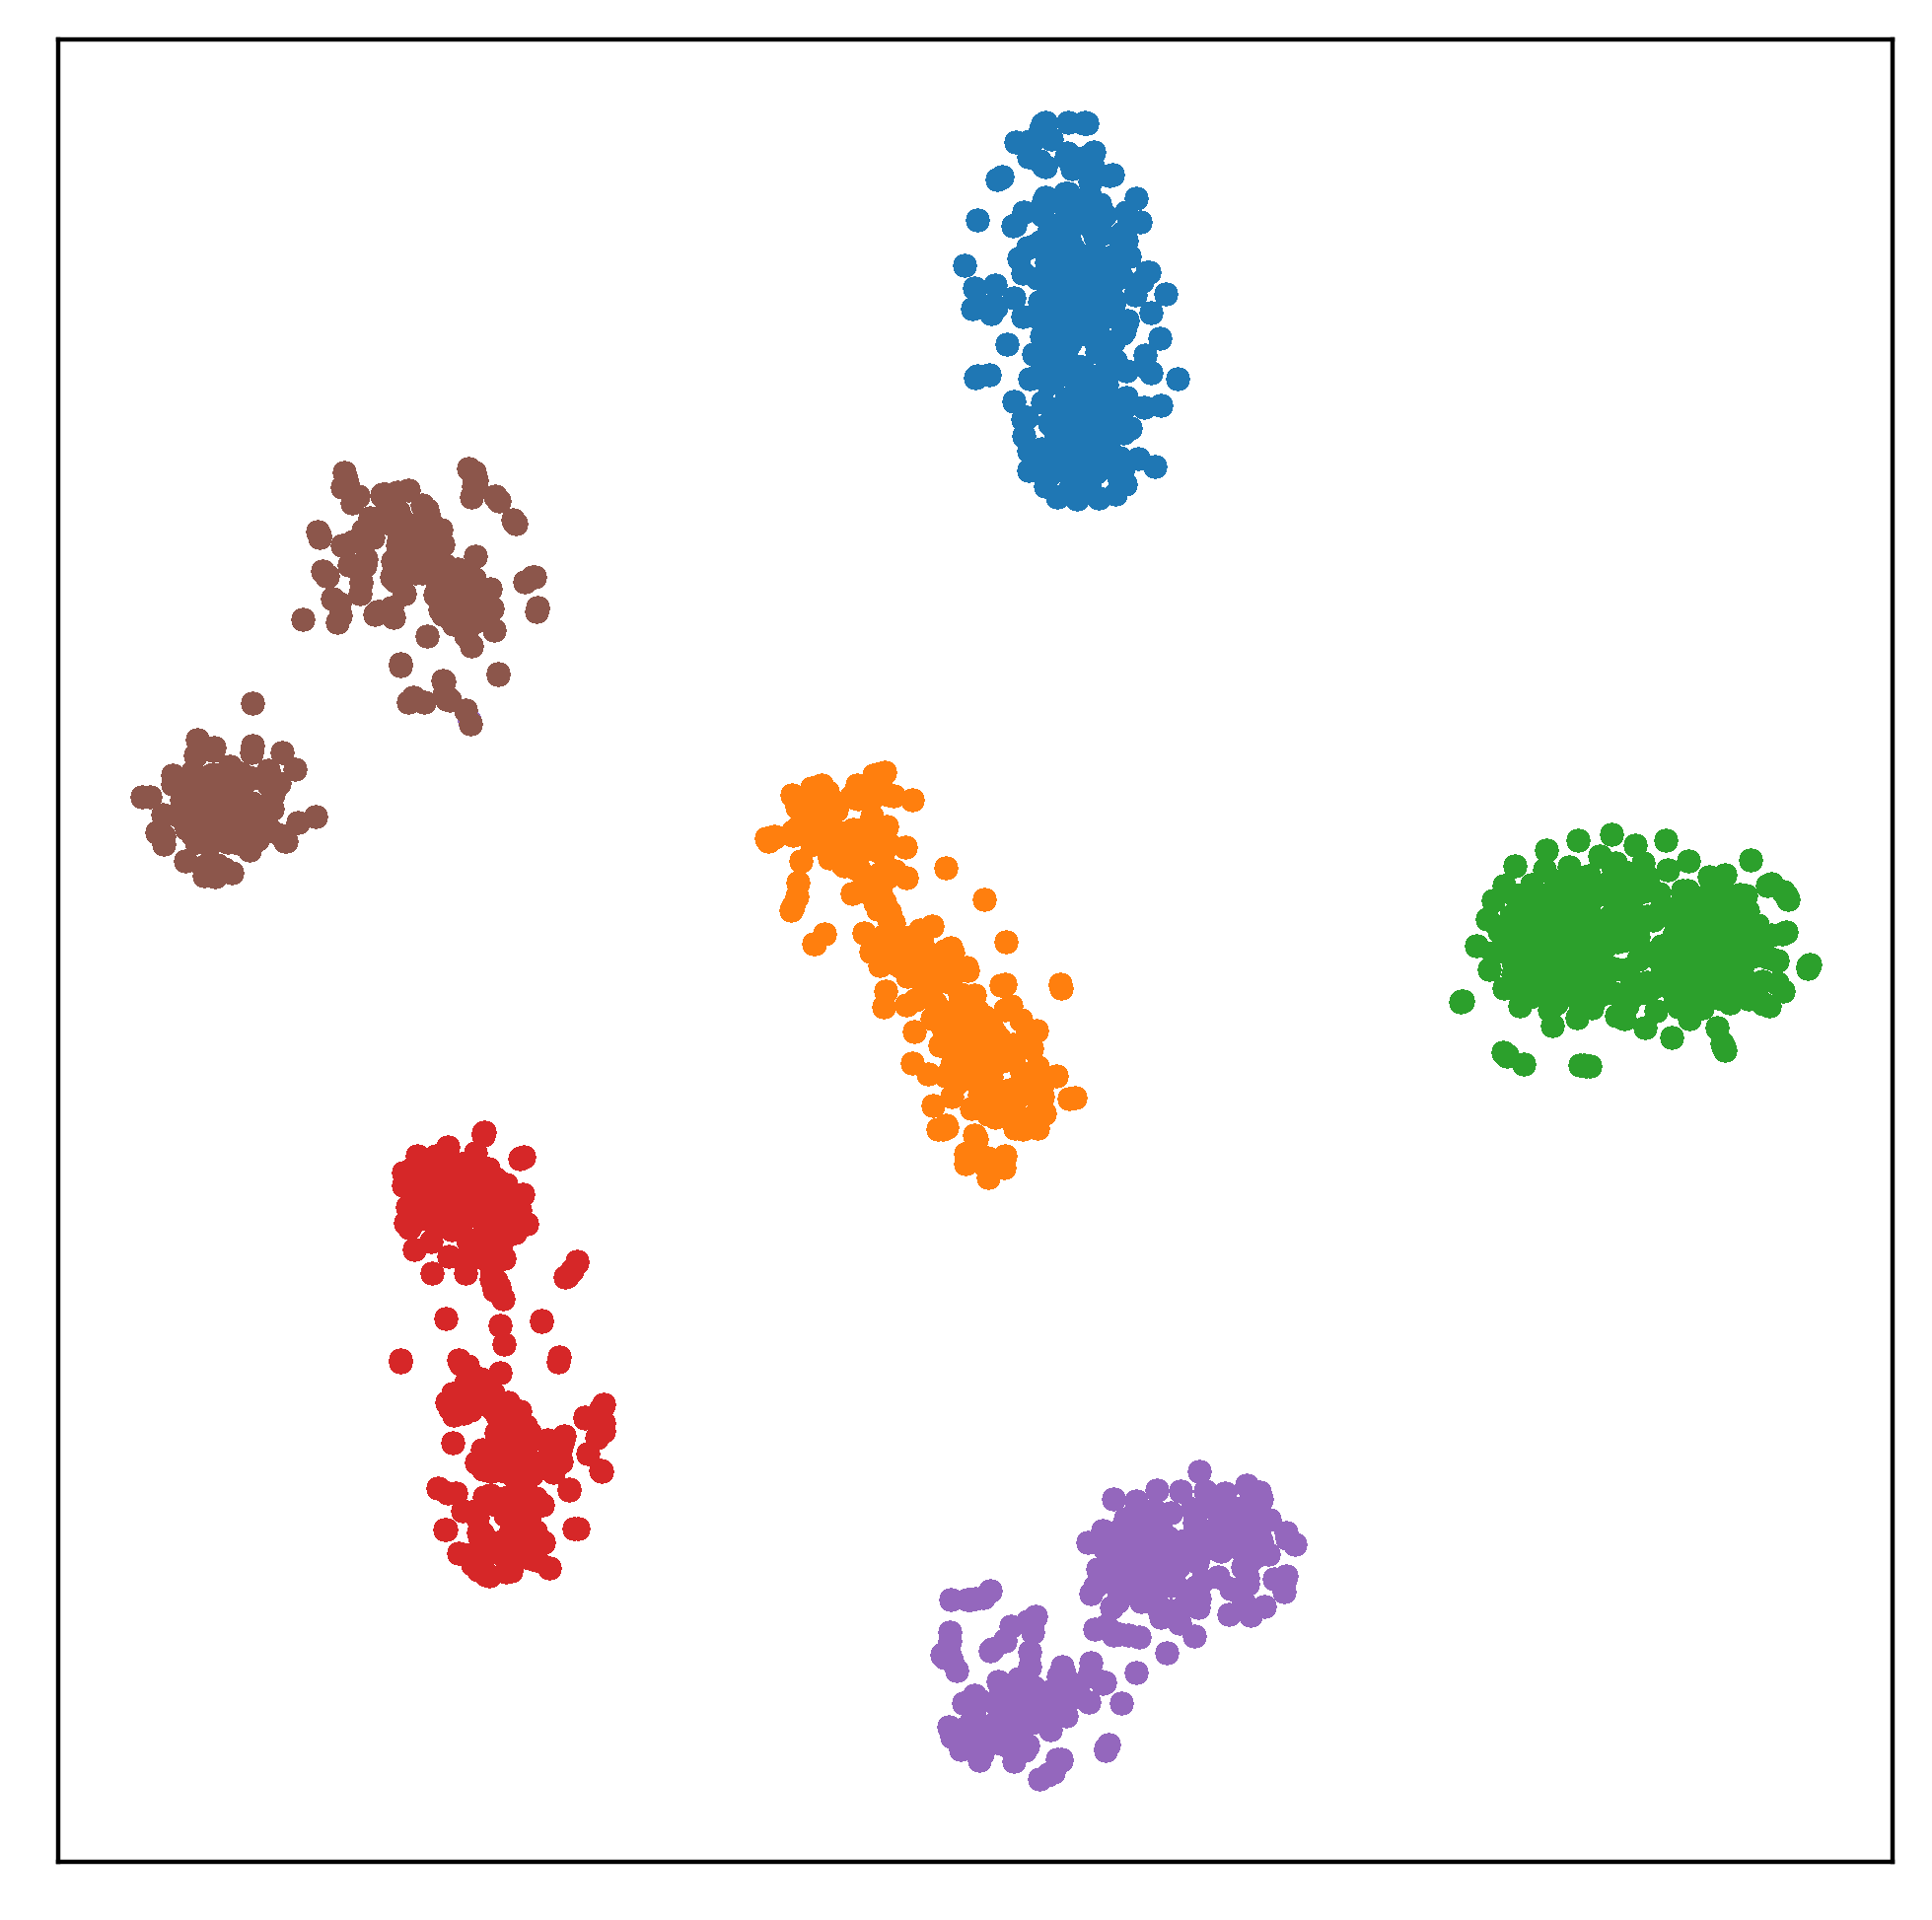

In [6]:
# plot TSNE
data_points = TSNE(n_components=2,
                   random_state=1,
                   perplexity=30,
                   init="random",
                   learning_rate="auto",
                   metric="precomputed").fit_transform(distance_matrix)
xdata = data_points[:, 0]
ydata = data_points[:, 1]

tmp_dict = {
    "xdata": xdata,
    "ydata": ydata,
    "label": labels,
}
df = pd.DataFrame(tmp_dict)
_plot(df)

/Users/nakayama/miniconda3/envs/mira/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


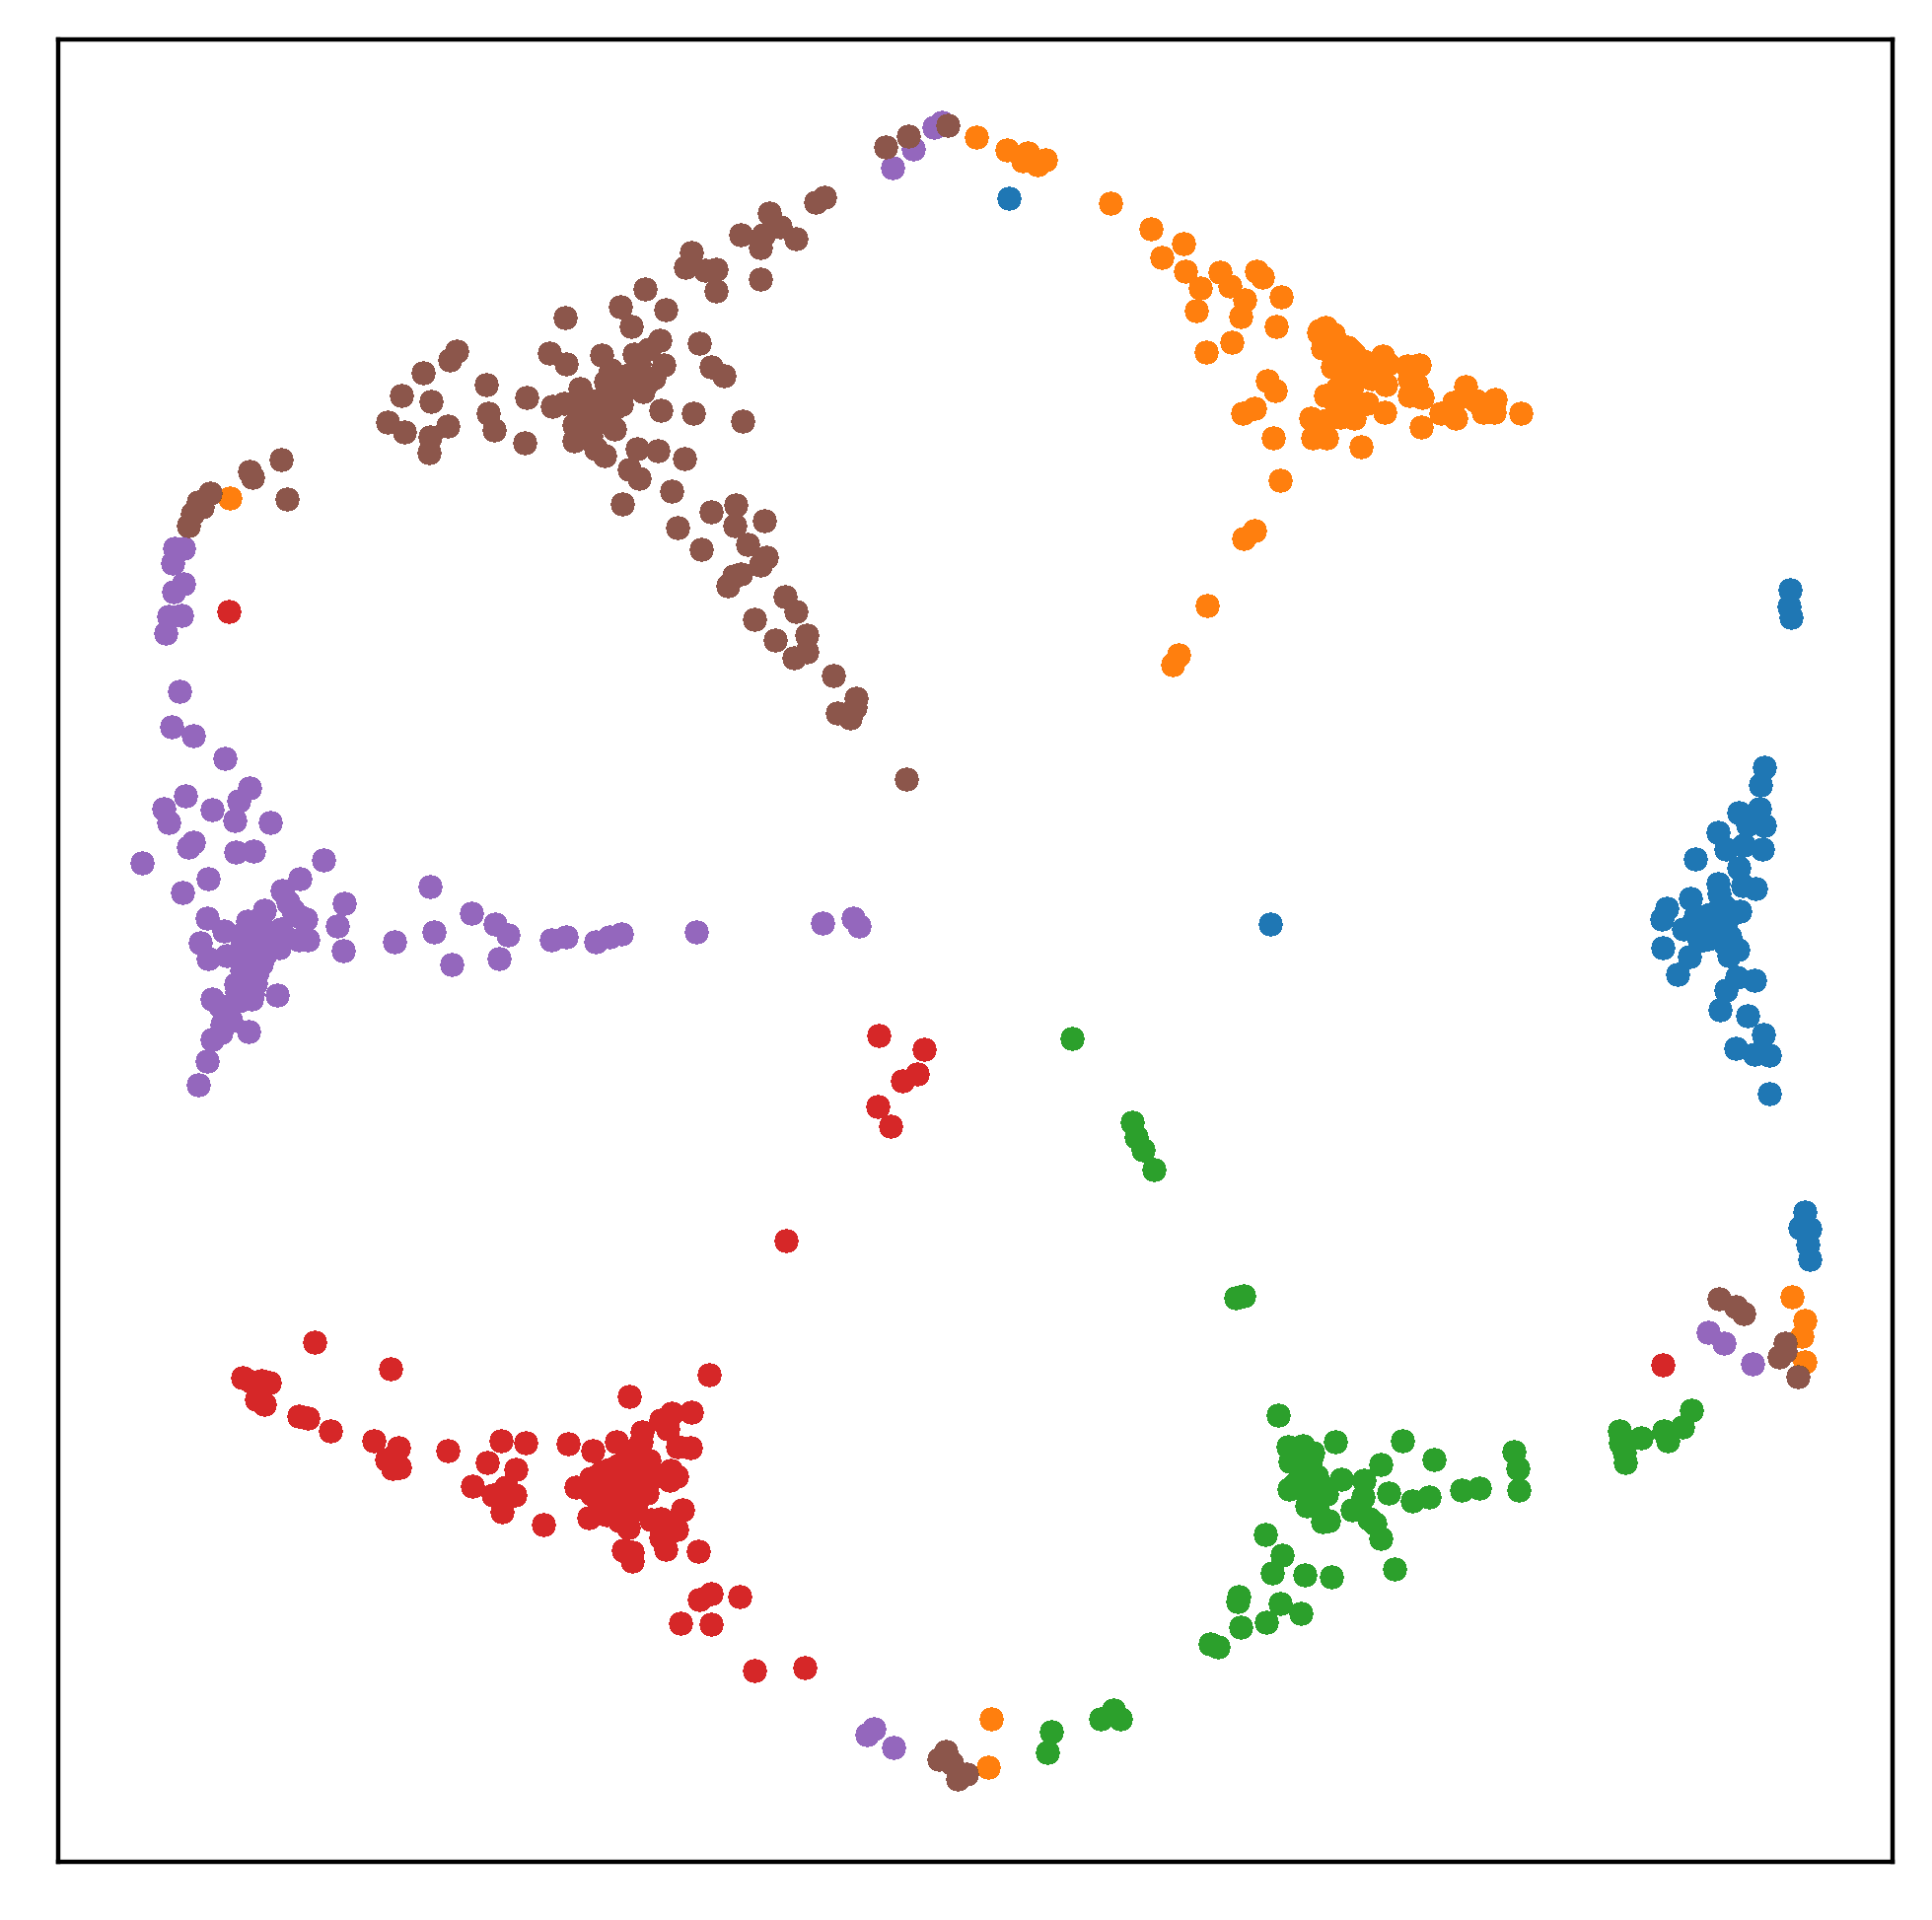

In [7]:
# plot MDS
data_points = MDS(n_components=2,
                  random_state=30,
                  dissimilarity="precomputed",
                  ).fit_transform(distance_matrix)
xdata = data_points[:, 0]
ydata = data_points[:, 1]

tmp_dict = {
    "xdata": xdata,
    "ydata": ydata,
    "label": labels,
}
df = pd.DataFrame(tmp_dict)
_plot(df)